In [1]:
import numpy as np
import sys, os
import argparse
import gc
import torch
import time
import h5py
import copy
import torchvision.models as models
import torch.nn as nn

#import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from utils import prf_utils, torch_utils, texture_utils, default_paths, nsd_utils
from model_fitting import initialize_fitting


dtype=np.float32

In [86]:
fn = '/user_data/mmhender/features/alexnet/S1_Conv5_ReLU_reflect_features_each_prf_grid3.h5py'

In [87]:
t = time.time()
with h5py.File(fn, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,800:810])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

Took 36.43813 seconds to load file


In [88]:
fn

'/user_data/mmhender/features/alexnet/S1_Conv5_ReLU_reflect_features_each_prf_grid3.h5py'

In [89]:
values.shape

(10000, 256, 10)

In [90]:
values[5000,50,:]

array([1.10019243e-03, 1.99753486e-04, 1.05832896e-05, 1.63614089e-07,
       7.82626797e-10, 2.63120933e-06, 5.53060818e-05, 3.90983565e-04,
       8.50546348e-04, 5.56515763e-04])

In [2]:
# Define sets of alexnet layers
alexnet_conv_layer_names = ['Conv1','Conv1_ReLU','Conv1_MaxPool', \
                       'Conv2','Conv2_ReLU','Conv2_MaxPool', \
                       'Conv3','Conv3_ReLU', \
                       'Conv4','Conv4_ReLU', \
                       'Conv5','Conv5_ReLU','Conv5_MaxPool']

alexnet_fc_layer_names = ['Dropout6','FC6','FC6_ReLU','Dropout7','FC7','FC7_ReLU','FC8']

n_feature_layers = len(alexnet_conv_layer_names)
n_classif_layers = len(alexnet_fc_layer_names)
n_total_layers = n_feature_layers + n_classif_layers
alexnet_layer_names = copy.deepcopy(alexnet_conv_layer_names)
alexnet_layer_names.extend(alexnet_fc_layer_names)

n_features_each_layer = [64,64,64, 192,192,192, 384,384, 256,256, 256,256]

In [4]:
subject = 1; 
use_node_storage = 0;
debug = 0;
which_prf_grid = 4;

In [6]:
# def get_features_each_prf(subject, use_node_storage=False, debug=False, which_prf_grid=1):
"""
Extract the portion of CNN feature maps corresponding to pRF defined in "models"
Return list of the features in each pRF, for each layer of interest.
"""
    
device = 'cpu:0'
# device = initialize_fitting.init_cuda()

if use_node_storage:
    alexnet_feat_path = default_paths.alexnet_feat_path_localnode
else:
    alexnet_feat_path = default_paths.alexnet_feat_path

# Load and prepare the image set to work with (all images for the current subject, 10,000 ims)
stim_root = default_paths.stim_root
image_data = nsd_utils.get_image_data(subject)  
image_data = nsd_utils.image_uncolorize_fn(image_data)

n_images = image_data.shape[0]

# Params for the spatial aspect of the model (possible pRFs)
aperture = 1.0
aperture_rf_range = 1.1
aperture, prf_models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, \
                                                         which_grid=which_prf_grid)    

# Fix these params
n_prf_sd_out = 2
batch_size = 50
mult_patch_by_prf = True
do_avg_pool = True

layers_to_return = ['Conv1_ReLU', 'Conv2_ReLU','Conv3_ReLU','Conv4_ReLU','Conv5_ReLU']
n_layers = len(layers_to_return)
layer_inds = [ll for ll in range(len(alexnet_layer_names)) \
                  if alexnet_layer_names[ll] in layers_to_return]

n_prfs = len(prf_models)
features_each_prf = [np.zeros((n_images, n_features_each_layer[ll], n_prfs),dtype=dtype) for ll in layer_inds]

n_batches = int(np.ceil(n_images/batch_size))


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255
number of pRFs: 1684
most extreme RF positions:
[0.   0.   0.04]
[ 1.2934314  -0.53575677  1.        ]


In [82]:
#     with torch.no_grad():

#         for bb in range(n_batches):

#             if debug and bb>1:
#                 continue
bb=50

print('Processing images for batch %d of %d'%(bb, n_batches))

batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))

# using grayscale images for better comparison w my other models.
# need to tile to 3 so alexnet weights will be right size
image_batch = np.tile(image_data[batch_inds,:,:,:], [1,3,1,1])

gc.collect()
torch.cuda.empty_cache()

# activ_batch_none = get_alexnet_activations_batch(image_batch, layer_inds, \
#                                             device=device, padding_mode=none)
activ_batch_zero = get_alexnet_activations_batch(image_batch, layer_inds, \
                                            device=device, padding_mode='zeros')
activ_batch_circ = get_alexnet_activations_batch(image_batch, layer_inds, \
                                            device=device, padding_mode='circular')
activ_batch_refl = get_alexnet_activations_batch(image_batch, layer_inds, \
                                            device=device, padding_mode='reflect')



Processing images for batch 50 of 200
Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
changed padding mode to zeros
Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
changed padding mode to zeros
Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
changed padding mode to zeros
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
changed padding mode to zeros
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
changed padding mode to zeros
hook for Conv1_ReLU
torch.Size([50, 64, 59, 59])
hook for Conv2_ReLU
torch.Size([50, 192, 29, 29])
hook for Conv3_ReLU
torch.Size([50, 384, 14, 14])
hook for Conv4_ReLU
torch.Size([50, 256, 14, 14])
hook for Conv5_ReLU
torch.Size([50, 256, 14, 14])
torch.Size([50, 64, 59, 59])
torch.Size([50, 192, 29, 29])
torch.Size([50, 384, 14, 14])
torch.Size([50, 256, 14, 14])
torch.Size([50, 256, 14, 14])
Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), padding_m

In [59]:
activ_batch_none = activ_batch

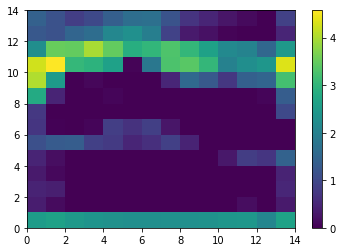

In [61]:
import matplotlib.pyplot as plt
plt.figure()
m = activ_batch_none[4][10,42,:,:].detach().cpu().numpy()
plt.pcolormesh(m)
plt.colorbar()

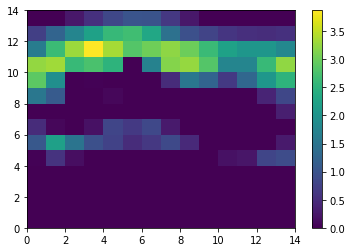

In [64]:
import matplotlib.pyplot as plt
plt.figure()
m = activ_batch_circ[4][10,42,:,:].detach().cpu().numpy()
plt.pcolormesh(m)
plt.colorbar()

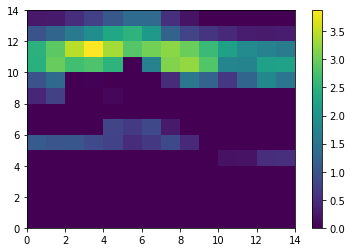

In [68]:
import matplotlib.pyplot as plt
plt.figure()
m = activ_batch_refl[4][10,42,:,:].detach().cpu().numpy()
plt.pcolormesh(m)
plt.colorbar()

Text(0.5, 1.0, 'reflected padding')

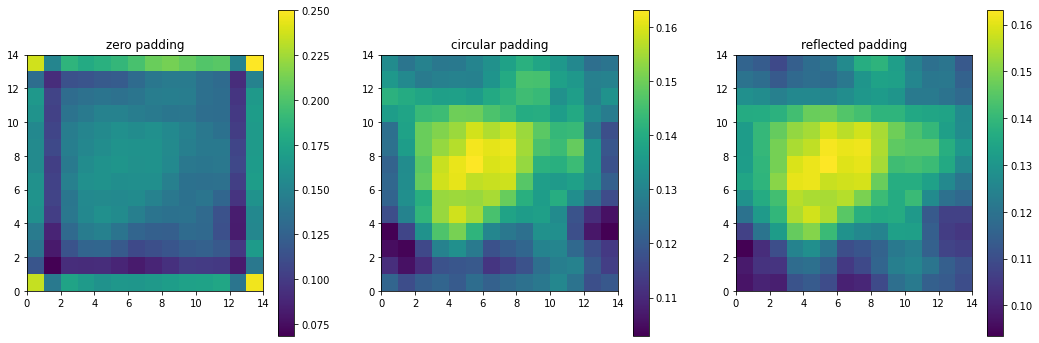

In [85]:

ll = 4

plt.figure(figsize=(18,6))

ab = activ_batch_zero[ll].detach().cpu().numpy()
edges_avg = np.mean(np.mean(ab,axis=0),axis=0);
plt.subplot(1,3,1)
plt.pcolormesh(edges_avg)
plt.colorbar()
plt.axis('square')
plt.title('zero padding')

ab = activ_batch_circ[ll].detach().cpu().numpy()
edges_avg = np.mean(np.mean(ab,axis=0),axis=0);
plt.subplot(1,3,2)
plt.pcolormesh(edges_avg)
plt.colorbar()
plt.axis('square')
plt.title('circular padding')

ab = activ_batch_refl[ll].detach().cpu().numpy()
edges_avg = np.mean(np.mean(ab,axis=0),axis=0);
plt.subplot(1,3,3)
plt.pcolormesh(edges_avg)
plt.colorbar()
plt.axis('square')
plt.title('reflected padding')


In [26]:
def get_alexnet_activations_batch(image_batch, layer_inds, device=None, padding_mode=None):

    """
    Get activations for images in NSD, passed through pretrained AlexNet.
    Specify which NSD images to look at, and which layers to return.
    """

    if device is None:
        device = torch.device('cpu:0')
       
    # first loading pre-trained model from torch model zoo
    model = models.alexnet(pretrained=True).float().to(device)
    if padding_mode is not None:
        for ff in model.features:
            if hasattr(ff, 'padding_mode'):
                ff.padding_mode=padding_mode
                print(ff)
                print('changed padding mode to %s'%padding_mode)
                
    model.eval()
    model_name='AlexNet'

    is_fc = [('FC' in alexnet_layer_names[ll] or 'fc' in alexnet_layer_names[ll]) for ll in layer_inds]
    
    if len(layer_inds)==0:
        raise ValueError('your layer names do not match any of those specified in alexnet_features.py')

    
    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii,ll):
        def hook(self, input, output):            
            print('hook for %s'%alexnet_layer_names[ll])           
            activ[ii] = output
            print(output.shape)
        return hook
   
    # get image and labels for this batch
    # image_tensors is [batch_size x 3 x 224 x 224]
    image_tensors =  torch_utils._to_torch(image_batch, device=device).float()
    activ = [[] for ll in layer_inds]
    hook = [[] for ll in layer_inds]
    
    model.eval()

    # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
    # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
    for ii, ll in enumerate(layer_inds):
        if not is_fc[ii]:
            h = model.features[ll].register_forward_hook(get_activ_fwd_hook(ii,ll))
        else:
            h = model.classifier[ll-n_feature_layers].register_forward_hook(get_activ_fwd_hook(ii,ll))
        hook[ii] = h

    # do the forward pass of model, which now includes the forward hooks
    # now the "activ" variable will get modified, because it gets altered during the hook function
    model(image_tensors)
    
    # Now remove all the hooks
    for ii, ll in enumerate(layer_inds):
        print(activ[ii].shape)
        hook[ii].remove

    return activ


    

In [8]:
if device is None:
    device = torch.device('cpu:0')

# first loading pre-trained model from torch model zoo
model = models.alexnet(pretrained=True).float().to(device)
model.eval()
model_name='AlexNet'

In [16]:
model.features[0].padding_mode = 'circular'
model.features[0].padding_mode

'circular'

In [23]:
[hasattr(model.features[ii],'padding_mode') for ii in range(len(model.features))]

[True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False]

In [ ]:
    is_fc = [('FC' in alexnet_layer_names[ll] or 'fc' in alexnet_layer_names[ll]) for ll in layer_inds]
    
    if len(layer_inds)==0:
        raise ValueError('your layer names do not match any of those specified in alexnet_features.py')

    
    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii,ll):
        def hook(self, input, output):            
            print('hook for %s'%alexnet_layer_names[ll])           
            activ[ii] = output
            print(output.shape)
        return hook
   
    # get image and labels for this batch
    # image_tensors is [batch_size x 3 x 224 x 224]
    image_tensors =  torch_utils._to_torch(image_batch, device=device).float()
    activ = [[] for ll in layer_inds]
    hook = [[] for ll in layer_inds]
    
    model.eval()

    # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
    # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
    for ii, ll in enumerate(layer_inds):
        if not is_fc[ii]:
            h = model.features[ll].register_forward_hook(get_activ_fwd_hook(ii,ll))
        else:
            h = model.classifier[ll-n_feature_layers].register_forward_hook(get_activ_fwd_hook(ii,ll))
        hook[ii] = h

    # do the forward pass of model, which now includes the forward hooks
    # now the "activ" variable will get modified, because it gets altered during the hook function
    model(image_tensors)
    
    # Now remove all the hooks
    for ii, ll in enumerate(layer_inds):
        print(activ[ii].shape)
        hook[ii].remove

In [25]:
#             for ll in range(n_layers):

#                 print('Getting prf-specific activations for layer %s'%alexnet_layer_names[layer_inds[ll]])

#                 maps_full_field = torch.moveaxis(activ_batch[ll], [0,1,2,3], [0,3,1,2])

#                 for mm in range(n_prfs):

#                     if debug and mm>1:
#                         continue

#                     prf_params = prf_models[mm,:]
#                     x,y,sigma = prf_params
#                     print('Getting features for pRF [x,y,sigma]:')
#                     print([x,y,sigma])
#                     n_pix = maps_full_field.shape[1]

#                     # Define the RF for this "model" version
#                     prf = torch_utils._to_torch(prf_utils.gauss_2d(center=[x,y], sd=sigma, \
#                                patch_size=n_pix, aperture=aperture, dtype=np.float32), device=device)
#                     minval = torch.min(prf)
#                     maxval = torch.max(prf-minval)
#                     prf_scaled = (prf - minval)/maxval

#                     if sigma==10:
#                         # creating a "flat" pRF here which will average across entire feature map.
#                         prf_scaled = torch.ones(prf_scaled.shape)
#                         prf_scaled = prf_scaled/torch.sum(prf_scaled)
#                         prf_scaled = prf_scaled.to(device)

#                     if mult_patch_by_prf:
#                         # This effectively restricts the spatial location, so no need to crop
#                         maps = maps_full_field * prf_scaled.view([1,n_pix, n_pix,1])
#                     else:
#                         # This is a coarser way of choosing which spatial region to look at
#                         # Crop the patch +/- n SD away from center
#                         bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, \
#                                                        min_pix=None, verbose=False, force_square=False)
#                         print('bbox to crop is:')
#                         print(bbox)
#                         maps = maps_full_field[:,bbox[0]:bbox[1], bbox[2]:bbox[3],:]

#                     if do_avg_pool:
#                         features_batch = torch.mean(maps, dim=(1,2))
#                     else:
#                         features_batch = torch.max(maps, dim=(1,2))

#                     print('model %d, min/max of features in batch: [%s, %s]'%(mm, \
#                                                   torch.min(features_batch), torch.max(features_batch))) 

#                     features_each_prf[ll][batch_inds,:,mm] = torch_utils.get_value(features_batch)

#         # Now save the results, one file for each alexnet layer 
#         for ii, ll in enumerate(layer_inds):
#             if which_prf_grid==1:
#                 fn2save = os.path.join(alexnet_feat_path, 'S%d_%s_features_each_prf.h5py'%(subject, \
#                                                                                    alexnet_layer_names[ll]))
#             else:
#                 fn2save = os.path.join(alexnet_feat_path, 'S%d_%s_features_each_prf_grid%d.h5py'%(subject, \
#                                                                       alexnet_layer_names[ll], which_prf_grid))
#             print('Writing prf features to %s\n'%fn2save)

#             t = time.time()
#             with h5py.File(fn2save, 'w') as data_set:
#                 dset = data_set.create_dataset("features", np.shape(features_each_prf[ii]), dtype=np.float64)
#                 data_set['/features'][:,:,:] = features_each_prf[ii]
#                 data_set.close()  
#             elapsed = time.time() - t

#             print('Took %.5f sec to write file'%elapsed)